In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

TelecomX = pd.read_excel("TelecomX_limpo.xlsx")
pd.set_option('display.max_columns', None)

#Drop coluna que não ajuda na previsão
TelecomX = TelecomX.drop("customerID", axis=1)

#Removendo linhas com valores ausentes
TelecomX = TelecomX.dropna()


#Transformar coluna em float
TelecomX["Charges.Total"] = TelecomX["Charges.Total"].replace(r'[^0-9.]', '', regex=True)
TelecomX["Charges.Total"] = pd.to_numeric(TelecomX["Charges.Total"], errors="coerce")

# Substituindo 11 NaN pela média da coluna
TelecomX["Charges.Total"].fillna(TelecomX["Charges.Total"].mean(), inplace=True)


#Verificando distribuiçãos dos valores das colunas Charges.Monthly e Charges.Total
TelecomX["Charges.Monthly"].hist(bins=30)
plt.title("Distribuição - Charges.Monthly")
plt.show()

TelecomX["Charges.Total"].hist(bins=30)
plt.title("Distribuição - Charges.Total")
plt.show()

print('Verificando distribuiçãos dos valores das colunas Charges.Monthly e Charges.Total')
print(TelecomX["Charges.Monthly"].quantile([0,0.25,0.5,0.75,1]))
print(TelecomX["Charges.Total"].quantile([0,0.25,0.5,0.75,1]))
print()
# Conferir distribuição
print()
print('Conferindo distribuição')
print()
TelecomX["tenure"].hist(bins=30)
plt.title("Distruibuição - Tenure")
plt.show()


# MonthlyCharges por quartis
TelecomX["MonthlyChargesGroup"] = pd.cut(
    TelecomX["Charges.Monthly"],
    bins=[0, 35.5, 70.35, 89.85, 120],
    labels=["Low (0-35)", "Medium (35-70)", "High (70-90)", "Very High (90-120)"],
    include_lowest=True
)

# TotalCharges por quartis
TelecomX["TotalChargesGroup"] = pd.cut(
    TelecomX["Charges.Total"],
    bins=[0, 402.2, 1400.55, 3768.65, 8700],
    labels=["New (0-400)", "Intermediate (400-1400)", "Experienced (1400-3700)", "Veteran (3700-8700)"],
    include_lowest=True
)

# Tenure por quartis
TelecomX['TenureGroup'] = pd.cut(
    TelecomX['tenure'],
    bins=[0, 1, 12, 24, 48, 60, 72],
    labels=['New (0-1 Month)', 'Young (1-12 Months)', 'Intermediate (1-2 Years)', 'Experienced (2-4 Years)', 'Loyal (4-5 Years)', 'Veteran (5+ Years)'],
    include_lowest=True
)

#Deletando as colunas que utilizei para criar os quartis
TelecomX = TelecomX.drop(['Charges.Monthly', 'Charges.Total', 'tenure'], axis=1)


# Inclua suas novas colunas de grupo explicitamente
cols_to_encode = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod', 'MonthlyChargesGroup',
    'TotalChargesGroup', 'TenureGroup'
]

# 2. Aplique o One-Hot Encoding apenas nas colunas selecionadas
# A coluna Churn já é numérica (0 e 1), então ela não precisa ser codificada
TelecomX_encoded = pd.get_dummies(TelecomX, columns=cols_to_encode, drop_first=True)

# Análise de correlação
print("\n=== Correlação com Churn ===")

# A coluna Churn já existe e é numérica, não precisamos de 'Churn_Yes'
corr = TelecomX_encoded.corr(numeric_only=True)["Churn"].sort_values(ascending=False)
print(corr.head(30))  # Top 10 mais correlacionadas
print(corr.tail(30))  # Menos correlacionadas


#Definição de variáveis preditivas (x) e (y) variável alvo 
X = TelecomX_encoded.drop("Churn", axis=1)
y = TelecomX_encoded["Churn"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Noramalizando as variáveis (coloca todas as colunas numéricas na mesma escola)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Separando o conjunto de dados para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Treinando e avaliando o modelo de Regressão Logística")

# Instanciando o modelo. max_iter=2000 é usado para garantir a convergência.
log_model = LogisticRegression(max_iter=2000)

# Treinando o modelo com os dados de treino
log_model.fit(X_train, y_train)

# Fazendo as previsões no conjunto de teste
y_pred_log = log_model.predict(X_test)

# Obtendo as probabilidades para o cálculo do ROC AUC
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# Exibindo as métricas de avaliação
print("\n--- Métricas da Regressão Logística ---")
print("Accuracy (Acurácia):", accuracy_score(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_log))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_log))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_log))





# Dados de previsão da Regressão Logística que você já tem
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_log)
auc_score = roc_auc_score(y_test, y_proba_log)

# Plotando a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Linha de Base Aleatória (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC - Regressão Logística')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()




# Matriz de Confusão da Regressão Logística que você já tem
cm = confusion_matrix(y_test, y_pred_log)

# Plotando a matriz de confusão como um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Churn (0)', 'Churn (1)'],
            yticklabels=['Não Churn (0)', 'Churn (1)'])
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()



=== ETAPA 1: CARREGAMENTO E PRÉ-PROCESSAMENTO DE DADOS              ===

--- Distribuição dos Dados Numéricos ---


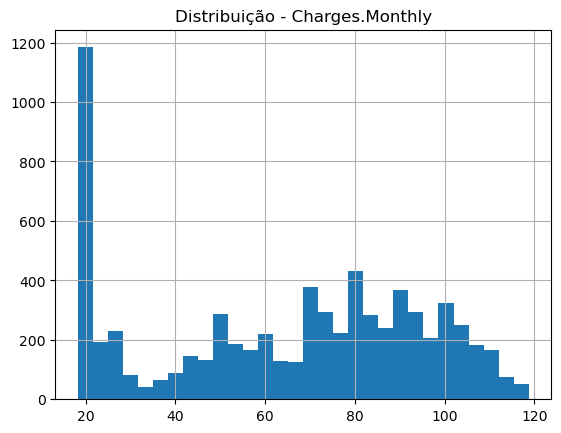

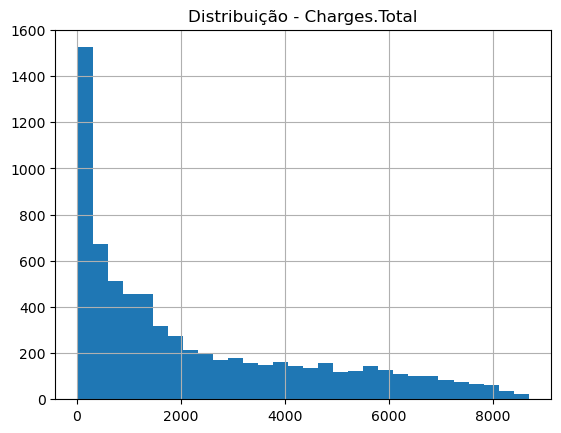

Verificando distribuiçãos dos valores das colunas Charges.Monthly e Charges.Total
0.00     18.25
0.25     35.50
0.50     70.35
0.75     89.85
1.00    118.75
Name: Charges.Monthly, dtype: float64
0.00      18.800
0.25     402.225
0.50    1400.550
0.75    3786.600
1.00    8684.800
Name: Charges.Total, dtype: float64


Conferindo distribuição



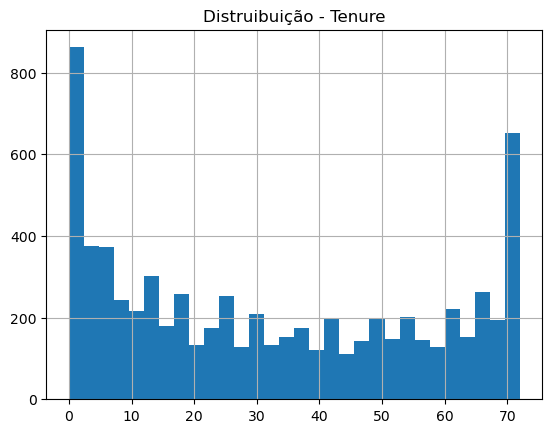



=== ETAPA 2: ANÁLISE DE CORRELAÇÃO                                  ===

--- Correlação com Churn ---
Churn                                        1.000000
InternetService_Fiber optic                  0.308020
PaymentMethod_Electronic check               0.301919
PaperlessBilling_1                           0.191825
TenureGroup_Young (1-12 Months)              0.187701
SeniorCitizen                                0.150889
MonthlyChargesGroup_High (70-90)             0.143243
MonthlyChargesGroup_Very High (90-120)       0.082833
StreamingTV_1                                0.063228
StreamingMovies_1                            0.061382
MultipleLines_1                              0.040102
TenureGroup_Intermediate (1-2 Years)         0.020308
PhoneService_1                               0.011942
gender_Male                                 -0.008612
TotalChargesGroup_Intermediate (400-1400)   -0.015830
MonthlyChargesGroup_Medium (35-70)          -0.025702
TotalChargesGroup_Experienced (1

In [3]:
# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


# =========================================================================
# ETAPA 1: CARREGAMENTO E PRÉ-PROCESSAMENTO DE DADOS
# =========================================================================
print("=======================================================================")
print("=== ETAPA 1: CARREGAMENTO E PRÉ-PROCESSAMENTO DE DADOS              ===")
print("=======================================================================")

TelecomX = pd.read_excel("TelecomX_limpo.xlsx")
pd.set_option('display.max_columns', None)

#Drop coluna que não ajuda na previsão
TelecomX = TelecomX.drop("customerID", axis=1)

#Removendo linhas com valores ausentes
TelecomX = TelecomX.dropna()


#Transformar coluna em float
TelecomX["Charges.Total"] = TelecomX["Charges.Total"].replace(r'[^0-9.]', '', regex=True)
TelecomX["Charges.Total"] = pd.to_numeric(TelecomX["Charges.Total"], errors="coerce")

# Substituindo 11 NaN pela média da coluna
TelecomX["Charges.Total"].fillna(TelecomX["Charges.Total"].mean(), inplace=True)

print("\n--- Distribuição dos Dados Numéricos ---")
#Verificando distribuiçãos dos valores das colunas Charges.Monthly e Charges.Total
TelecomX["Charges.Monthly"].hist(bins=30)
plt.title("Distribuição - Charges.Monthly")
plt.show()

TelecomX["Charges.Total"].hist(bins=30)
plt.title("Distribuição - Charges.Total")
plt.show()

print('Verificando distribuiçãos dos valores das colunas Charges.Monthly e Charges.Total')
print(TelecomX["Charges.Monthly"].quantile([0,0.25,0.5,0.75,1]))
print(TelecomX["Charges.Total"].quantile([0,0.25,0.5,0.75,1]))
print()

# Conferir distribuição
print()
print('Conferindo distribuição')
print()
TelecomX["tenure"].hist(bins=30)
plt.title("Distruibuição - Tenure")
plt.show()

# MonthlyCharges por quartis
TelecomX["MonthlyChargesGroup"] = pd.cut(
    TelecomX["Charges.Monthly"],
    bins=[0, 35.5, 70.35, 89.85, 120],
    labels=["Low (0-35)", "Medium (35-70)", "High (70-90)", "Very High (90-120)"],
    include_lowest=True
)

# TotalCharges por quartis
TelecomX["TotalChargesGroup"] = pd.cut(
    TelecomX["Charges.Total"],
    bins=[0, 402.2, 1400.55, 3768.65, 8700],
    labels=["New (0-400)", "Intermediate (400-1400)", "Experienced (1400-3700)", "Veteran (3700-8700)"],
    include_lowest=True
)

# Tenure por quartis
TelecomX['TenureGroup'] = pd.cut(
    TelecomX['tenure'],
    bins=[0, 1, 12, 24, 48, 60, 72],
    labels=['New (0-1 Month)', 'Young (1-12 Months)', 'Intermediate (1-2 Years)', 'Experienced (2-4 Years)', 'Loyal (4-5 Years)', 'Veteran (5+ Years)'],
    include_lowest=True
)

#Deletando as colunas que utilizei para criar os quartis
TelecomX = TelecomX.drop(['Charges.Monthly', 'Charges.Total', 'tenure'], axis=1)


# Inclua suas novas colunas de grupo explicitamente
cols_to_encode = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod', 'MonthlyChargesGroup',
    'TotalChargesGroup', 'TenureGroup'
]

# 2. Aplique o One-Hot Encoding apenas nas colunas selecionadas
# A coluna Churn já é numérica (0 e 1), então ela não precisa ser codificada
TelecomX_encoded = pd.get_dummies(TelecomX, columns=cols_to_encode, drop_first=True)


# =========================================================================
# ETAPA 2: ANÁLISE DE CORRELAÇÃO
# =========================================================================
print("\n\n=======================================================================")
print("=== ETAPA 2: ANÁLISE DE CORRELAÇÃO                                  ===")
print("=======================================================================")
# Análise de correlação
print("\n--- Correlação com Churn ---")
# A coluna Churn já existe e é numérica, não precisamos de 'Churn_Yes'
corr = TelecomX_encoded.corr(numeric_only=True)["Churn"].sort_values(ascending=False)
print(corr.head(30))  # Top 10 mais correlacionadas
print(corr.tail(30))  # Menos correlacionadas


# =========================================================================
# ETAPA 3: MODELAGEM - REGRESSÃO LOGÍSTICA
# =========================================================================
print("\n\n=======================================================================")
print("=== ETAPA 3: MODELAGEM - REGRESSÃO LOGÍSTICA                        ===")
print("=======================================================================")

#Definição de variáveis preditivas (x) e (y) variável alvo
X = TelecomX_encoded.drop("Churn", axis=1)
y = TelecomX_encoded["Churn"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Normalizando as variáveis (coloca todas as colunas numéricas na mesma escola)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Separando o conjunto de dados para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("\n--- Treinando e Avaliando o Modelo de Regressão Logística ---")

# Instanciando o modelo. max_iter=2000 é usado para garantir a convergência.
log_model = LogisticRegression(max_iter=2000)

# Treinando o modelo com os dados de treino
log_model.fit(X_train, y_train)

# Fazendo as previsões no conjunto de teste
y_pred_log = log_model.predict(X_test)

# Obtendo as probabilidades para o cálculo do ROC AUC
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# Exibindo as métricas de avaliação
print("\n--- Métricas da Regressão Logística ---")
print("Accuracy (Acurácia):", accuracy_score(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_log))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_log))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_log))
